In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [3]:
from data_analysis import Dataset

In [4]:
run_label = '20210707' ## Change this to look at different runs
d = Dataset(run_label=run_label, gases=['O2', 'CO2'])

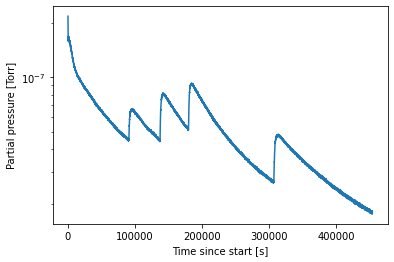

In [5]:
d.GetData()
d.FindPeaks()
d.GetRanges()
d.PlotSingleGas('CO2')

[[2.98594678e+04 9.22964937e+03 2.28301244e+08]]


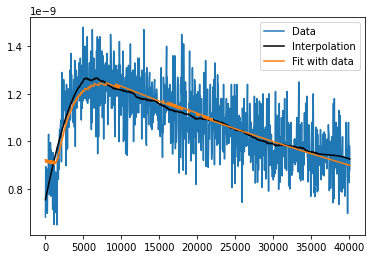

[[1.74600771e+04 9.14221743e+03 1.14689288e+08]]


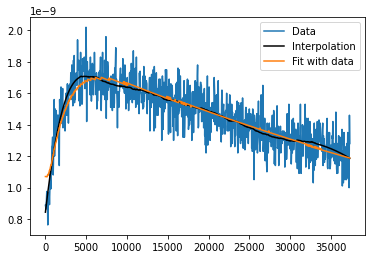

[[2.37893167e+00 6.45824415e+03 1.27694510e+04]]


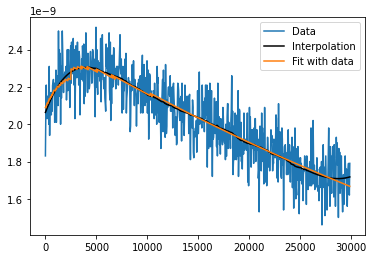

[[5.18466828e+04 9.85308329e+03 2.16271096e+08]]


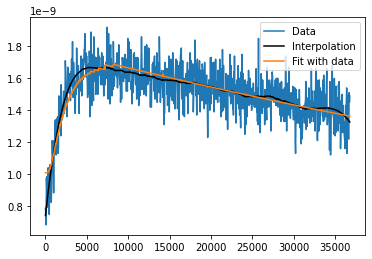

In [6]:
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d


a_range = np.arange(0, 10000, 1000)
b_range = np.arange(0, 10000, 1000)
for i,gas in enumerate(d.gases):
    if gas =='CO2':
        continue
    for j, fitrange in enumerate(d.range[gas]):
#         try: 
        plt.figure()
        
        if j < 2:
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:fitrange[1]] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:fitrange[1]]
            temp = np.array(d.data[gas]['ch2_lerp'])[fitrange[0]:fitrange[1]]
            sample_temp = np.array(d.data[gas]['mean_temp'])[fitrange[0]:fitrange[1]]
        elif j < (len(d.range[gas]) - 1) :
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]
            temp = np.array(d.data[gas]['ch2_lerp'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]
            sample_temp = np.array(d.data[gas]['mean_temp'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]
        else:
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:int(fitrange[0]+(len(d.data[gas]['exp_time'])-1-fitrange[0])/4)] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:int(fitrange[0]+(len(d.data[gas]['pressure'])-1-fitrange[0])/4)]
            temp = np.array(d.data[gas]['ch2_lerp'])[fitrange[0]:int(fitrange[0]+(len(d.data[gas]['ch2_lerp'])-1-fitrange[0])/4)]
            sample_temp = np.array(d.data[gas]['mean_temp'])[fitrange[0]:int(fitrange[0]+(len(d.data[gas]['mean_temp'])-1-fitrange[0])/4)]

        # interpolation to smooth out the noise
        xx = np.linspace(xdata.min(),xdata.max(), len(xdata))
        itp = interp1d(xdata,ydata, kind='linear')
        window_size, poly_order = 201, 3
        yy_sg = savgol_filter(itp(xx), window_size, poly_order)


        plt.plot(xdata,ydata, label='Data')
        plt.plot(xx,yy_sg, label='Interpolation', c='k')

        
        i=1
        popt_list = []
        chi_list_data = []
        chi_list_inter = []
        for x in a_range:
            for y in b_range:
                i += 1
                #a, b = fsolve(constraint_eq, (x, y))
                try:
                    popt,pcov = curve_fit(d.fitfunction, [xdata,temp], ydata, p0=[x, y, 0.005])
                    fit = d.fitfunction([xdata,temp], *popt)
                    chi_data = np.sum((fit - ydata)**2 / fit)
                    chi_inter = np.sum((fit - yy_sg)**2 / fit)
                    popt_list.append(popt)
                    chi_list_data.append(chi_data)
                    chi_list_inter.append(chi_inter)
                except:
                    pass
        popt_list = np.array(popt_list)
        chi_list_data = np.array(chi_list_data)
        chi_list_inter = np.array(chi_list_inter)
        pfit = popt_list[np.where(chi_list_data==np.min(chi_list_data))]
        pfit_inter = popt_list[np.where(chi_list_inter==np.min(chi_list_inter))]
        
        
        plt.plot(xdata, d.fitfunction([xdata,temp], *pfit[0]), label='Fit with data')
        #plt.plot(xdata, d.fitfunction([xdata,temp], *pfit_inter[0]), label='Fit with interpolation')
        print(pfit)
        plt.legend(loc='upper right')
        #plt.savefig('{}_peakfit.png'.format(sample_temp[0]))
        plt.show()
#         except:
#             pass

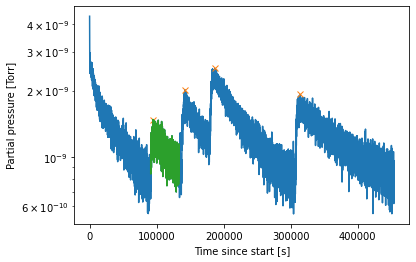

In [7]:
gas = 'O2'
d.PlotSingleGas(gas)
plt.plot(np.array(d.data[gas]['exp_time'])[d.peak_indices[gas]], 
         np.array(d.data[gas]['pressure'])[d.peak_indices[gas]], 'x')
plt.plot(np.array(d.data[gas]['exp_time'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
         np.array(d.data[gas]['pressure'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
         ls='-')

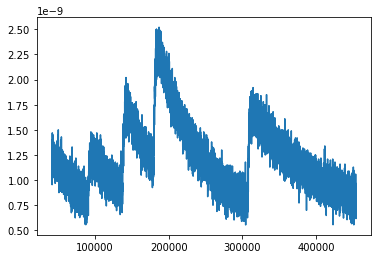

In [8]:
gas = 'O2'
# d.PlotSingleGas(gas)
plt.plot(np.array(d.data[gas]['exp_time'])[1000:], 
         np.array(d.data[gas]['pressure'])[1000:])
# plt.plot(np.array(d.data[gas]['exp_time'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
#          np.array(d.data[gas]['pressure'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
#          ls='-')

In [9]:
d.range[gas]

[[2159, 3127], [3307, 4208], [4388, 7283], [7403, -1]]

[[1.81753602e+02 7.67577568e+03 2.48297852e+05]]
[[1.49811488e+02 7.61826584e+03 2.03789611e+05]]


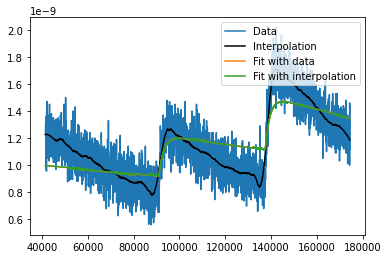

In [19]:
c_range = np.arange(0, 100000, 10000)
for i,gas in enumerate(d.gases):
    if gas =='CO2':
        continue
    xdata = np.array(d.data[gas]['exp_time'])[1000:d.range[gas][1][1]]
    ydata = np.array(d.data[gas]['pressure'])[1000:d.range[gas][1][1]]
    temp = np.array(d.data[gas]['ch2_lerp'])[1000:d.range[gas][1][1]]
    sample_temp = np.array(d.data[gas]['mean_temp'])[1000:d.range[gas][1][1]]
    
    plt.figure()
    # interpolation to smooth out the noise
    xx = np.linspace(xdata.min(),xdata.max(), len(xdata))
    itp = interp1d(xdata,ydata, kind='linear')
    window_size, poly_order = 201, 3
    yy_sg = savgol_filter(itp(xx), window_size, poly_order)

    
    plt.plot(xdata,ydata, label='Data')
    plt.plot(xx,yy_sg, label='Interpolation', c='k')
    
    
    i=1
    popt_list_data = []
    chi_list_data = []
    popt_list_inter = []
    chi_list_inter = []
    #scanning through a range of possible parameter values to find the best fit via minimizing the chi-squared value
    for x in a_range:
        for y in b_range:
            for z in c_range:
                i += 1
                #a, b = fsolve(constraint_eq, (x, y))
                try:
                    #fitting the data
                    popt,pcov = curve_fit(d.fitfunction, [xdata,temp], ydata, p0=[x, y, z])
                    fit = d.fitfunction([xdata,temp], *popt)
                    chi_data = np.sum((fit - ydata)**2 / fit)
                    
                    #fitting the interpolation
                    popt_inter, pcov_inter = curve_fit(d.fitfunction, [xx,temp], yy_sg, p0=[x, y, z])
                    fit_inter = d.fitfunction([xx,temp], *popt_inter)
                    chi_inter = np.sum((fit - yy_sg)**2 / fit)
                    
                    popt_list_data.append(popt)
                    popt_list_inter.append(popt_inter)
                    chi_list_data.append(chi_data)
                    chi_list_inter.append(chi_inter)
                except:
                    pass
    
    #finding the min chi-squared value of the fits
    popt_list = np.array(popt_list_data)[np.array(chi_list_data) > 0]
    chi_list_data = np.array(chi_list_data)[np.array(chi_list_data) > 0]
    popt_list_inter = np.array(popt_list_inter)[np.array(chi_list_inter) > 0]
    chi_list_inter = np.array(chi_list_inter)[np.array(chi_list_inter) > 0]
    
    pfit = popt_list[np.where(chi_list_data==np.min(chi_list_data))]
    pfit_inter = popt_list_inter[np.where(chi_list_inter==np.min(chi_list_inter))]
    print(pfit)
    print(pfit_inter)
    #for pfit in popt_list:
    plt.plot(xdata, d.fitfunction([xdata,temp], *pfit[0]), label='Fit with data')
    plt.plot(xdata, d.fitfunction([xx,temp], *pfit_inter[0]), label='Fit with interpolation')
    plt.legend(loc='upper right')
    #plt.savefig('{}_peakfit.png'.format(sample_temp[0]))
    plt.show()

In [ ]:
print(np.min(chi_list_data))